# adding GC data, combine the chroms and add the PON coverage for log2ratio

In [1]:
# get the code
import sys
import os
import matplotlib.pyplot as plt
sys.path.append('../code')

# import package functions
from script_utils_CNV import get_CNVconfig, show_output

# HOME
home = '/Users/mahtin'
home = '/Users/martinscience'

# standard paths
static = os.path.join(home, "Dropbox/Icke/Work/static")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
PON_path = os.path.join(static, "PON/HAEv7_hg38_NovaSeq")
 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")

### get the config
+ use the get_CNVconfig util function to update the general configs with the appropriate paths

In [2]:
path_config = dict(
        cov_path=os.path.join(output_path, "pile2CNV"),   # path containing cov.gz files for this sample
        snp_path=os.path.join(output_path, "pile2CNV"),   # path containing snp files for this sample
        PON_path = PON_path,
    )
CNVconfig = get_CNVconfig(
    "../config/config_CNV.yaml", 
    local_config=path_config)

## run the code

In [3]:
from combineCNV import combine_sample_CNV
sample="03_A-B"

cov_df, snp_df = combine_sample_CNV(sample, config=CNVconfig)

# cov_df.to_csv(os.path.join(output_path, f"cov/{sample}.cov.gz"), sep="\t", index=False, compression="gzip")
# snp_df.to_csv(os.path.join(output_path, f"snp/{sample}.snp.gz"), sep="\t", index=False, compression="gzip")

Loading data for sample 03_A-B
Loading coverage file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr1.cov.gz
Loading snp file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr1.snp
Loading coverage file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr2.cov.gz
Loading snp file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr2.snp
Loading coverage file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr3.cov.gz
Loading snp file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr3.snp
Loading coverage file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr4.cov.gz
Loading snp file /Users/martinscience/Dropbox/Icke/Work/somVar/tooldata/myCNVdata/output/pile2CNV/03_A-B.chr4.snp
Loading coverage file /Us

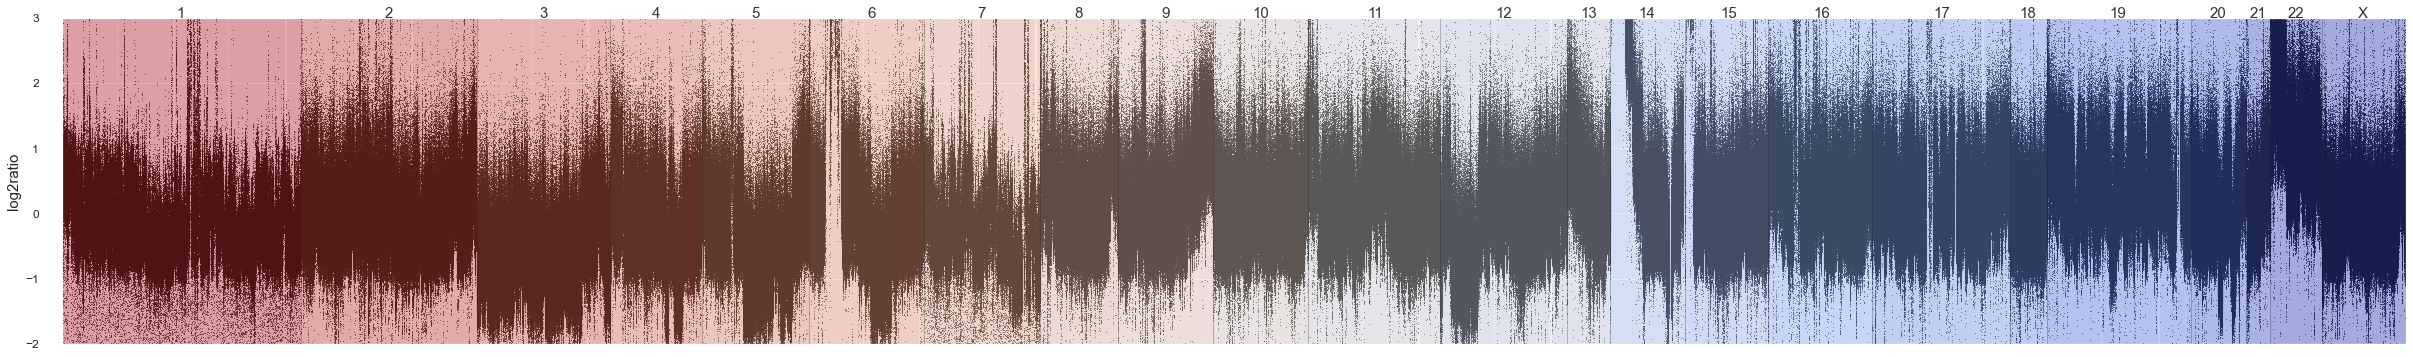

In [4]:
from plot import plot_cov
fig_params = dict(
    figsize=(42,6),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-2,3)
)
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio2',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=.5,
            alpha=.7
        ))


fig, ax, _, chrom_df = plot_cov(cov_df, plots=[log2], chroms='all', region='', **fig_params)

In [5]:
fig.savefig(os.path.join(cnvdata, "figures/03_noGC_cov.jpeg"))

### rerun without GC norm


In [ ]:
CNVconfig['coverage']['GCnormalize'] = False
cov_df, snp_df = combine_sample_CNV(sample, config=CNVconfig)
cov_df.to_csv(os.path.join(output_path, f"cov/{sample}.noGC.cov.gz"), sep="\t", index=False, compression="gzip")

## Step by step

### A) get coverge for all chroms and concat

In [ ]:
def combine_chrom_cnv(sample, 
                     config={}
    ):
    '''
    combine the coverages for all chroms and add the GC ratio
    '''
    
    cov_dfs = []
    snp_dfs = []
    chrom_list = [f"chr{c + 1}" for c in range(22)] + ['chrX']
    for chrom in chrom_list:
        cov_file = os.path.join(config['cov_path'], f"{sample}.{chrom}.cov.gz")
        snp_file = os.path.join(config['snp_path'], f"{sample}.{chrom}.snp")
        show_output(f"Loading coverage file {cov_file}")
        cov_df = pd.read_csv(cov_file, sep="\t", compression="gzip")
        show_output(f"Loading snp file {snp_file}")
        snp_df = pd.read_csv(snp_file, sep="\t")
        cov_dfs.append(cov_df)
        snp_dfs.append(snp_df)
    cov_df = pd.concat(cov_dfs).reset_index(drop=True)
    snp_df = pd.concat(snp_dfs).reset_index(drop=True)
    # make chrom categorical
    cov_df.loc[:, "Chr"] = pd.Categorical(cov_df['Chr'], chrom_list)
    snp_df.loc[:, "Chr"] = pd.Categorical(snp_df['Chr'], chrom_list)
    return cov_df, snp_df

In [ ]:
sample="03_A-B"
cov_df, snp_df = combine_chrom_cnv(
    sample, 
    config=CNVconfig
)
# look at general stats
cov_df.groupby("Chr").agg({"Cov1": "mean", "Cov2": "mean", "Pos":['count', 'min', 'max']}).sort_values("Chr")

In [ ]:
snp_df

## B) normalize GC ratio

###  Visualize GC bias

In [ ]:
from plot import make_GC_plot
fig, _ = make_GC_plot(cov_df, sample=sample)
fig.savefig(os.path.join(cnvdata, "figures/GC_03_A-B.jpeg"))

### normalize to 100

In [ ]:
from combineCNV import normalize_GC, normalize  # see notebook "combinePONcoverage"
normGC_cov_df = normalize_GC(cov_df)
norm_cov_df = normalize(cov_df)
del cov_df
fig, _ = make_GC_plot(normGC_cov_df, sample=sample)
fig.savefig(os.path.join(cnvdata, "figures/GC_03_GCnorm.jpeg"))
fig, _ = make_GC_plot(norm_cov_df, sample=sample)
fig.savefig(os.path.join(cnvdata, "figures/GC_03_norm.jpeg"))

## C) coverage: merge sample coverage with Pon coverage

In [ ]:
pon_cov_df = pd.read_csv(os.path.join(CNVconfig['PON_path'], "pon.cov.filter.gz"), sep="\t", compression="gzip")
pon_cov_df

In [ ]:
def get_full_exon_pos(*dfs, pon_cov_df):
    '''
    adds the accumulated exonic position (over all chroms from PON data) to coverage df
    '''
    
    # create chrom_df from pon_df
    chrom_df = pon_cov_df.groupby("Chr").agg(dict(ExonPos=["min","max"]))["ExonPos"]
    chrom_df['chrAdd'] = chrom_df['max'].cumsum().shift(fill_value=0)
    chrom_df = chrom_df.loc[:, 'chrAdd'].reset_index()
    
    full_dfs = []
    for df in dfs:
        # merge with chrom_df
        df = df.merge(chrom_df)  
        # get FullExonPos from ExonPos and chrAdd
        df.loc[:, 'FullExonPos'] = df['ExonPos'] + df['chrAdd']
    
        # get col index of "ExonPos" for adjacent inserting of "FullExonPos" 
        insert_index = df.columns.get_loc("ExonPos") + 1
        cols = list(df.columns)
        out_cols = cols[:insert_index] + ["FullExonPos"] + cols[insert_index:-2]
        full_dfs.append(df.loc[:, out_cols])
    return full_dfs

In [ ]:
full_cov_df, full_snp_df = get_full_exon_pos(norm_cov_df, snp_df, pon_cov_df=pon_cov_df)
del norm_cov_df
del snp_df
full_cov_df

In [ ]:
merge_cov_df = full_cov_df.merge(pon_df)
del full_cov_df
del pon_df
merge_cov_df

In [ ]:
def log2ratio(df, cov_col, pon_cov_col='PONcov_mean'):
    '''
    add log2ratio (log2(COV/PONCOV) to coverage data
    '''
    # get the incoming columns
    cols = list(df.columns)
    # mask rows where logging does not compute
    loggable = df[cov_col] * df['PONcov_mean'] != 0
    # apply the log
    log_col = cov_col.replace("Cov", "log2ratio")
    df.loc[loggable, log_col] = np.log2(df.loc[loggable, cov_col] / df.loc[loggable, pon_cov_col])
    # get col index of cov_col for inserting log_col
    insert_index = df.columns.get_loc(cov_col) + 1
    out_cols = cols[:insert_index] + [log_col] + cols[insert_index:]
    return df.loc[:, out_cols]

In [ ]:
for col in merge_cov_df.columns:
    if col.startswith("Cov"):     
        merge_cov_df = log2ratio(merge_cov_df, col)
merge_cov_df

### merge snp with PON snp

In [ ]:
pon_snp_df = pd.read_csv(os.path.join(CNVconfig['PON_path'], "pon.snp.gz"), sep="\t", compression="gzip")
pon_snp_df

In [ ]:
full_snp_df.merge(pon_snp_df, how="left")

In [ ]:
def combine_sample_CNV(sample, config={}):
    '''
    combined snp and cov sample data
    adds FullExonPos to both files

    COV:
        performs GC normalization
        adds the PON coverage and computes log2ratio coverage
    SNP:
        adds PON VAF to sample SNP data for filtering

    '''

    # ## LOAD
    show_output(f"Loading data for sample {sample}")
    # combine chrom SNP and COV data for that sample
    cov_df, snp_df = combine_chrom_cnv(sample, config=config)
    show_output("Finished", color="success")

    # ## NORMALIZE
    # get config
    if (config['coverage']['GCnormalize']):
        show_output("Normalizing coverage using GCratio segmentation")
        cov_df = normalize_GC(cov_df)
        # use GC PON
        PON_cov_file = os.path.join(config['PON_path'], "CNV/pon.cov.filterGC.gz")
    else:
        cov_df = normalize(cov_df)
        # use nonGC PON
        PON_cov_file = os.path.join(config['PON_path'], "CNV/pon.cov.filter.gz")

    # ## INCLUDE PON
    if os.path.isfile(PON_cov_file):
        show_output(f"Loading PON coverage from {PON_cov_file}")
        pon_cov_df = pon_cov_df = pd.read_csv(PON_cov_file, sep="\t", compression="gzip")
    else:
        show_output(f"PON coverage file {PON_cov_file} not found!", color="warning")
        return

    show_output("Adding FullExonPos from PON coverage to coverage and snp data.")
    cov_df, snp_df = get_full_exon_pos(cov_df, snp_df, pon_cov_df=pon_cov_df)
    show_output("Merging coverage with PON coverage and performing log2ratio computation.")
    cov_df = cov_df.merge(pon_cov_df)

    del pon_cov_df
    for col in cov_df.columns:
        if col.startswith("Cov"):     
            cov_df = log2ratio(cov_df, col)
    show_output("log2ratio computation finished.", color="success")

    # PON snp
    PON_snp_file = os.path.join(config['PON_path'], "CNV/pon.snp.gz")
    if os.path.isfile(PON_snp_file):
        show_output(f"Loading PON SNP from {PON_cov_file} and merging into sample SNP data.")
        pon_snp_df = pon_snp_df = pd.read_csv(PON_snp_file, sep="\t", compression="gzip")
    else:
        show_output(f"PON snp file {PON_snp_file} not found!", color="warning")
        return
    snp_df = snp_df.merge(pon_snp_df, how="left")
    show_output(f"Finished combining data for sample {sample}")
    return cov_df, snp_df

In [ ]:
# from combineCNV import combine_sample_CNV

In [ ]:
cov_df, snp_df = combine_sample_CNV("03_A-B", config=CNVconfig)
cov_df[:10]

In [ ]:
snp_df[:10]

In [ ]:
CNVconfig = get_CNVconfig(
    "../config/config_CNV.yaml", 
    local_config=path_config)
cov_df, snp_df = filter_CNV(cov_df, snp_df, config=CNVconfig)
cov_df